# Signal Modulation classification 3
Experiment with architecture and data

**References**:
- [Original SIMC2](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)
- [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/pdf/1602.04105.pdf)
- [Automatic Signal Modulation Recognition based on Deep Convolutional Neural Network](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi8gNXSl5b9AhWn-yoKHRtdCGUQFnoECBIQAQ&url=https%3A%2F%2Fwww.atlantis-press.com%2Farticle%2F125913178.pdf&usg=AOvVaw1NhM3rX7_Ve6yQoFJlmecP)

Mixed dataset v2 - snr [0..30] with step 1. 30k samples per modulation

## Imports

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple

sys.path.append("..") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [4]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = True
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "../data/RML2016.10a/RML2016.10a_dict.pkl" # radioml dataset
TRAIN_DATA_DIR = "/development/data/Mixed_V2/train_data_SIMC1_SNR_mixed_0-30_30k/"

# Deployment
# model_name = "simc_2_mixed_0-30_data"
model_name = "simc_3_MIXED_v2_no_quant"
# MODELS_DIR = f'models_{model_name}_MIXED_0-30_DATA/'
MODELS_DIR = f'models_{model_name}_MIXED_v2/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
snrs = [0, 5, 10, 15, 20, 25, 30]


Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
# reload_module("tools.data")
# from tools.data import load_data_simc_v2
# # labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR)
# labels, data = load_data_simc_v2(
#     classes=modulations, 
#     path=Path(TRAIN_DATA_DIR), 
#     model_dtype=MODEL_DATA_TYPE, 
#     frames_per_mod=30_000
# )

labels, data = np.load("../final_models_evaluation/labels_mixed_V2_0_30_30k.npy"), np.load("../final_models_evaluation/data_mixed_V2_0_30_30k.npy")

# Commented code loads mixed datasst 
# snr_to_labels_data = {}
# for snr in snrs:
#     print(f"snr={snr}")
#     labels, data = load_data_simc_v1(
#         classes=modulations, 
#         path=Path(TRAIN_DATA_DIR) / f"train_data_SIMC1_2k_SNR_{snr}", 
#         model_dtype=MODEL_DATA_TYPE
#     )
#     snr_to_labels_data[snr] = (labels, data)


In [6]:
print(modulations)
print(labels.shape)
print(data.shape)

# crmrn_ds_keys = list(crmrn_ds.keys())
# print(crmrn_ds_keys)
# print(len(crmrn_ds.keys())) # 20 (snr -20 to 20 with step 2) * 11
# for key in crmrn_ds:
#     print(len(crmrn_ds[key]), end=", ")
# print()
# print(crmrn_ds[list(crmrn_ds.keys())[0]].shape)

['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(330000,)
(330000, 1, 1024, 2)


### Data preprocessing

There are 27_500 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [6]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [7]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [9]:
# Should save some memory
del data
del labels

## Model creation


In [10]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_simc_2():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

# [1 ]
def create_model_simc_3_stable():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

In [11]:
model = create_model_simc_3_stable()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 re_lu (ReLU)                (None, 1, 1024, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 512, 32)       0         
 )                                                               
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        12336     
                                                             

In [12]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)



In [13]:
def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# N_EPOCHS = 16 
# BATCH_SIZE = 256
N_EPOCHS = 16
BATCH_SIZE = 128
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


Epoch 1/16
2063/2063 [==============================] - 53s 23ms/step - loss: 0.4081 - accuracy: 0.8456 - val_loss: 0.3647 - val_accuracy: 0.8572 - lr: 0.0010
Epoch 2/16
2063/2063 [==============================] - 48s 23ms/step - loss: 0.3065 - accuracy: 0.8842 - val_loss: 0.3217 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 3/16
2063/2063 [==============================] - 48s 23ms/step - loss: 0.2817 - accuracy: 0.8945 - val_loss: 0.3557 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 4/16
2063/2063 [==============================] - 48s 23ms/step - loss: 0.2654 - accuracy: 0.9006 - val_loss: 0.2916 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 5/16
2063/2063 [==============================] - 48s 24ms/step - loss: 0.2508 - accuracy: 0.9066 - val_loss: 0.2605 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 6/16
2063/2063 [==============================] - 49s 24ms/step - loss: 0.2404 - accuracy: 0.9100 - val_loss: 0.2848 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 7/16
2063/2063 [========================

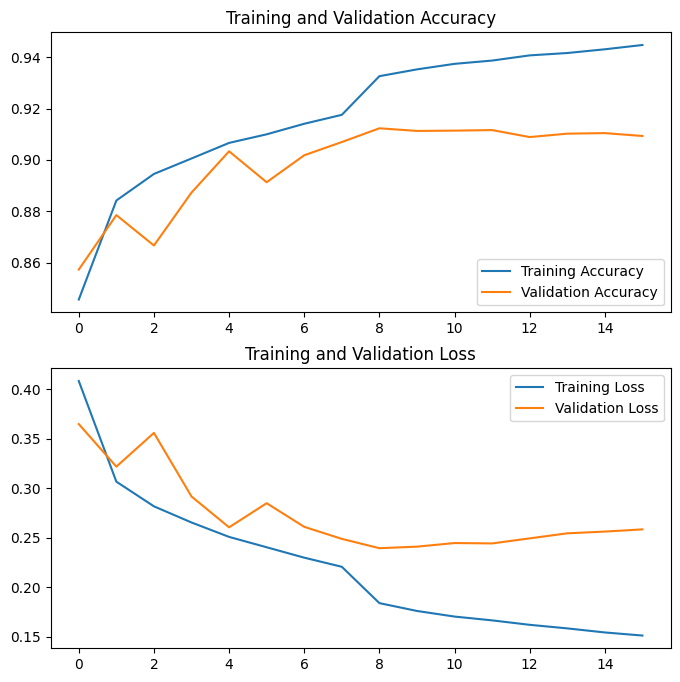

In [14]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

snrs = range(0, 30)

def model_predict(model, data, *args, **kwargs):
    return model.predict(data, *args, **kwargs)

def evaluate_model(model, data, labels, verbose=True, predict_func=model_predict):
    # preds = model.predict(data)
    preds = predict_func(model, data)
    pred_labels = np.argmax(preds, axis=1)

    cls_to_acc = {"Overall": accuracy_score(labels, pred_labels)}
    print(f"Overall test accuracy: {cls_to_acc}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(labels == ci)[0]
        cur_true_labels = labels[class_indecies]
        cur_pred_labels = pred_labels[class_indecies]
        cls_to_acc[cl] = accuracy_score(cur_true_labels, cur_pred_labels)
        verbose and print(f"{cl} test accuracy: {cls_to_acc[cl]}")
    cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
    verbose and print(cm)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    if verbose:
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
    return cm, cls_to_acc


def get_snr_to_acc(model, data, labels, indecies, minimum_snr=-100, verbose=True, predict_func=model_predict):
    def snr_by_idx(idx):
        snr_idx = (idx % 30000) // 1000
        # snr_idx = (idx % 30000) // 500
        return snrs[snr_idx]

    cur_snrs = np.array([snr_by_idx(idx) for idx in indecies])

    snr_to_acc = {}
    for snr in snrs:
    # for snr in range(0, 30):
        cur_indecies = np.where(cur_snrs == snr)[0]
        cur_data = data[cur_indecies]
        cur_labels = labels[cur_indecies]
        # cur_pred = model.predict(cur_data, verbose=0)
        cur_pred = predict_func(model, cur_data, verbose=0)
        cur_pred_labels = np.argmax(cur_pred, axis=1)
        verbose and print(f"snr={snr}")
        acc = accuracy_score(cur_labels, cur_pred_labels)
        verbose and print(f"Overall test accuracy: {acc}")
        snr_to_acc[snr] = acc
    return snr_to_acc

1032/1032 [==============================] - 2s 2ms/step
Overall test accuracy: {'Overall': 0.9061212121212121}
16QAM test accuracy: 0.89086859688196
64QAM test accuracy: 0.9747304582210242
8PSK test accuracy: 0.7345924453280318
B-FM test accuracy: 1.0
BPSK test accuracy: 0.7671414375621066
CPFSK test accuracy: 0.9993178717598908
DSB-AM test accuracy: 0.9268211920529801
GFSK test accuracy: 0.9850498338870431
PAM4 test accuracy: 0.8768768768768769
QPSK test accuracy: 0.9194915254237288
SSB-AM test accuracy: 0.9007815154604145
[[2800   63   99    0   18    0    2    6   58   97    0]
 [  74 2893    0    0    0    0    0    0    1    0    0]
 [  39    0 2217    0  540    0   62    9   68   82    1]
 [   0    0    0 2882    0    0    0    0    0    0    0]
 [   1    0  382    0 2316    0  216    8   95    0    1]
 [   0    0    1    0    0 2930    0    0    0    1    0]
 [   0    0    2    0   99    0 2799    1    0    0  119]
 [   2    0   21    0    9    0    6 2965    6    1    0]
 [  4

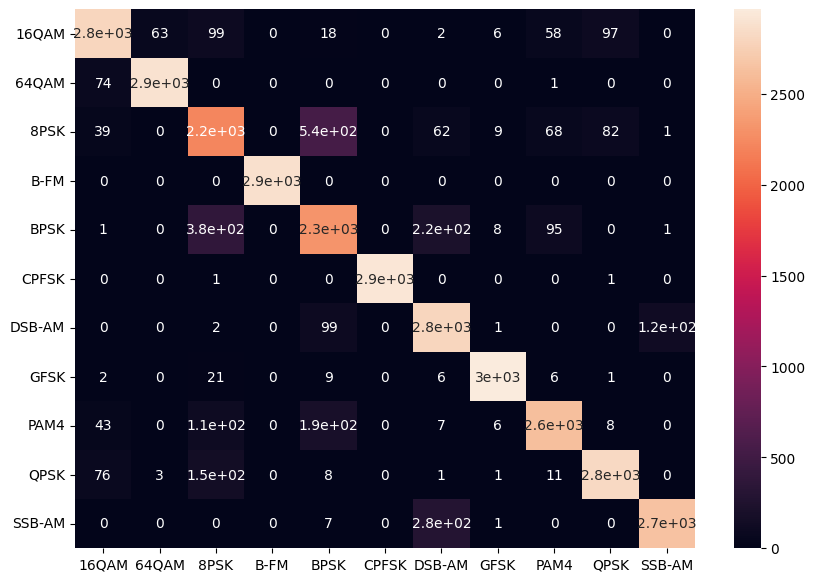

In [16]:
cm_test, cls_to_acc_test = evaluate_model(model, test_data, test_labels, verbose=True)
snr_to_acc_test = get_snr_to_acc(model, test_data, test_labels, test_indecies, verbose=True)

In [17]:
# pred_labels = np.argmax(test_preds, axis=1)
# print(pred_labels[0:10])
# print(test_labels[0:10])

In [18]:
# from sklearn.metrics import accuracy_score, confusion_matrix
# print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
# for ci, cl in enumerate(modulations):
#     class_indecies = np.where(test_labels == ci)[0]
#     cur_test_labels = test_labels[class_indecies]
#     cur_pred_labels = pred_labels[class_indecies]
#     print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
# cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# df_cm = pd.DataFrame(cm, index = modulations,
#                   columns = modulations)
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)

In [19]:
# snrs = list(range(0, 30))
# def snr_by_idx(idx):
#     snr_idx = (idx % 30000) // 1000
#     return snrs[snr_idx]


In [20]:
# print(test_indecies[:40])
# test_snrs = np.array([snr_by_idx(idx) for idx in test_indecies])
# print(test_snrs[:40])
# print(test_indecies.shape)

In [21]:
# snr_to_acc = {}
# for snr in range(0, 30):
#     cur_test_indecies = np.where(test_snrs == snr)[0]
#     cur_test_data = test_data[cur_test_indecies]
#     cur_test_labels = test_labels[cur_test_indecies]
#     cur_pred = model.predict(cur_test_data, verbose=0)

#     cur_pred_labels = np.argmax(cur_pred, axis=1)
#     print(f"snr={snr}")
#     acc = accuracy_score(cur_test_labels, cur_pred_labels)
#     print(f"Overall test accuracy: {acc}")
#     snr_to_acc[snr] = acc


(0.0, 1.0)

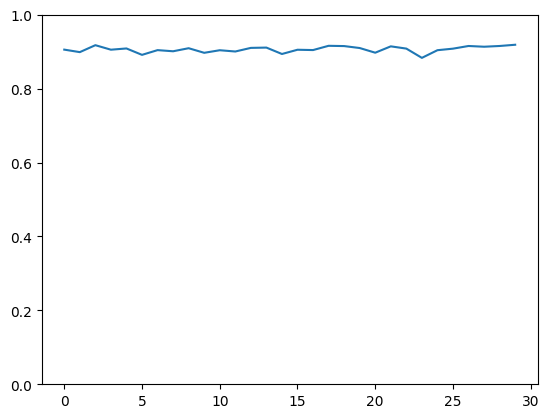

In [22]:
plt.plot(list(snr_to_acc_test.keys()), list(snr_to_acc_test.values()))
plt.ylim([0, 1])

In [23]:
# plt.plot([0, 5, 10, 15, 20, 25, 30], [0.49772727272727274 ,0.6522727272727272, 0.7654545454545455, 0.8245454545454546, 0.8581818181818182, 0.86, 0.8686363636363637])
# plt.ylim([0, 1])

### Mode deployment

In [24]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_3_MIXED_v2_no_quant_MIXED_v2/model/assets


INFO:tensorflow:Assets written to: models_simc_3_MIXED_v2_no_quant_MIXED_v2/model/assets


In [25]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

1545588

In [26]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [8]:
model = tf.keras.models.load_model("../final_models_evaluation/CNN_mixed_v2_0-30_0/experiment_0/model/")

8250/8250 [==============================] - 13s 2ms/step
Overall test accuracy: {'Overall': 0.937844696969697}
16QAM test accuracy: 0.9479834150018847
64QAM test accuracy: 0.975874096835811
8PSK test accuracy: 0.8240910607071381
B-FM test accuracy: 0.9999170434277656
BPSK test accuracy: 0.8694872863693206
CPFSK test accuracy: 0.9997915450679563
DSB-AM test accuracy: 0.9580778375672632
GFSK test accuracy: 0.9926344423519565
PAM4 test accuracy: 0.9168572022448556
QPSK test accuracy: 0.9373381234856714
SSB-AM test accuracy: 0.8943220936502011
[[22635   183   479     0    70     0     5     8   124   373     0]
 [  571 23501     0     0     0     0     0     0     0    10     0]
 [  144     0 19765     0  3260     0   190    39   238   348     0]
 [    0     2     0 24107     0     0     0     0     0     0     0]
 [    8     0  1823     0 20859     0  1006    26   268     0     0]
 [    0     0     1     0     0 23981     0     1     0     3     0]
 [    0     0     6     0   644     0 2

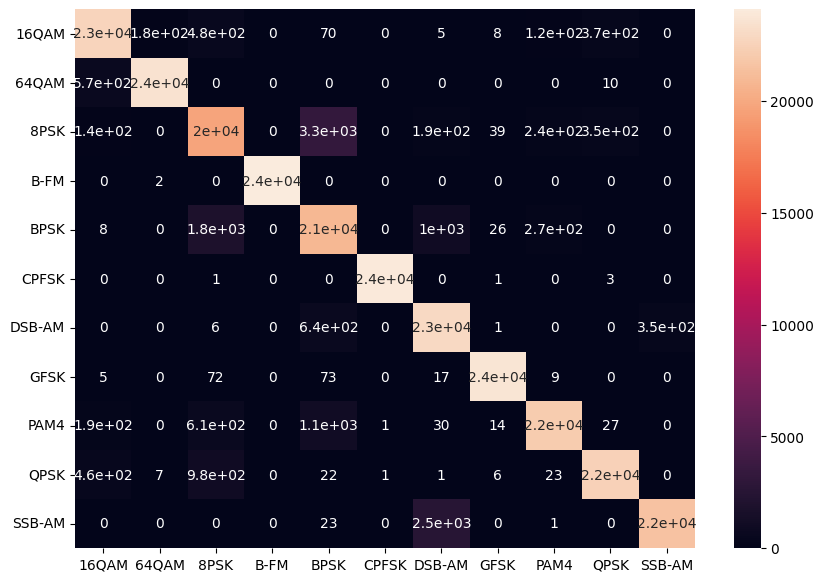

In [13]:
# cm_test, cls_to_acc_test = evaluate_model(model, test_data, test_labels, verbose=True)
# snr_to_acc_test = get_snr_to_acc(model, test_data, test_labels, test_indecies, verbose=True)
cm_test, cls_to_acc_test = evaluate_model(model, train_data, train_labels, verbose=True)
snr_to_acc_test = get_snr_to_acc(model, train_data, train_labels, train_indecies, verbose=True)

In [27]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


409296

In [28]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import predict_tflite

def predict_quant(model, data, *args, **kwargs):
    return np.squeeze(predict_tflite(model, data))

# test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

In [29]:
# pred_labels_quant = np.argmax(test_preds_quant, axis=1)
# print(pred_labels_quant[:10])
# print(test_labels[:10])

In [30]:
# print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
# for ci, cl in enumerate(modulations):
#     class_indecies = np.where(test_labels == ci)[0]
#     cur_test_labels = test_labels[class_indecies]
#     cur_pred_labels = pred_labels_quant[class_indecies]
#     print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

# cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
# df_cm = pd.DataFrame(cm, index = modulations,
#                   columns = modulations)
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Overall test accuracy: {'Overall': 0.9048181818181819}
16QAM test accuracy: 0.8848234171174038
64QAM test accuracy: 0.9794474393530997
8PSK test accuracy: 0.723326706428098
B-FM test accuracy: 1.0
BPSK test accuracy: 0.7807220934084134
CPFSK test accuracy: 0.9996589358799455
DSB-AM test accuracy: 0.9463576158940398
GFSK test accuracy: 0.9870431893687708
PAM4 test accuracy: 0.8732065398732065
QPSK test accuracy: 0.8983050847457628
SSB-AM test accuracy: 0.8888888888888888
[[2781   89  104    0   21    0    2    7   54   85    0]
 [  60 2907    0    0    0    0    0    0    1    0    0]
 [  45    0 2183    0  600    0   67   13   70   39    1]
 [   0    0    0 2882    0    0    0    0    0    0    0]
 [   2    0  324    0 2357    0  243    9   84    0    0]
 [   0    0    1    0    0 2931    0    0    0    0    0]
 [   0    0    0    0   88    0 2858    1    0    0   73]
 [   3    0   14    1   10    0    6 2971    5    0    0]
 [  49    0   94    0  218    0    8    7 2617    4    0]
 [ 

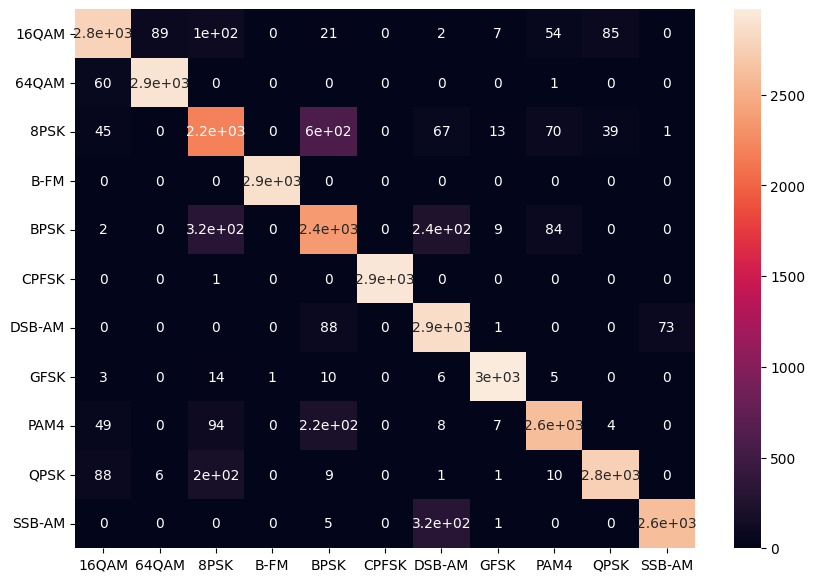

In [31]:
cm_test_quant, cls_to_acc_test_quant = evaluate_model(model_tflite, test_data, test_labels, verbose=True, predict_func=predict_quant)
snr_to_acc_test_quant = get_snr_to_acc(model_tflite, test_data, test_labels, test_indecies, verbose=True, predict_func=predict_quant)

In [32]:
import json 

quant_results = {
    # "model_configuration": model_configuration,
    # "train_history": train_history,
    # "cm_val": cm_val.tolist(),
    # "cls_to_acc_val": cls_to_acc_val,
    # "snr_to_acc_val": snr_to_acc_val,

    # "cm_test": cm_test.tolist(),
    # "cls_to_acc_test": cls_to_acc_test,
    # "snr_to_acc_test": snr_to_acc_test,

    "cm_test_quant": cm_test_quant.tolist(),
    "cls_to_acc_test_quant": cls_to_acc_test_quant,
    "snr_to_acc_test_quant": snr_to_acc_test_quant,
}

results = {
    # "model_configuration": model_configuration,
    # "train_history": train_history,
    # "cm_val": cm_val.tolist(),
    # "cls_to_acc_val": cls_to_acc_val,
    # "snr_to_acc_val": snr_to_acc_val,

    "cm_test": cm_test.tolist(),
    "cls_to_acc_test": cls_to_acc_test,
    "snr_to_acc_test": snr_to_acc_test,

    # "cm_test_quant": cm_test_quant.tolist(),
    # "cls_to_acc_test_quant": cls_to_acc_test_quant,
    # "snr_to_acc_test_quant": snr_to_acc_test_quant,
}


with open("quant_results.json", "w") as res_file:
    json.dump(quant_results, res_file, indent=4)

with open("no_quant_results.json", "w") as res_file:
    json.dump(results, res_file, indent=4)

In [41]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.02734375 0.         0.890625   0.         0.0078125  0.
 0.         0.         0.05078125 0.02734375 0.        ]


In [53]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_no_quant_tflite,
    # model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=True,
    epsilon=20,
    apply_quantization=False,
)

[debug] Export test data


11it [00:00, 364.86it/s]
